In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore") 
pd.set_option("display.max_columns", None) # 设置 Pandas 显示选项，显示所有列
cut_type = 'peryear' # 定义切分类型为按年
train_type = 'scilearn' # 定义训练类型为 scikit-learn
data_type = 'all' # 定义数据类型为所有数据

df_asset_details = pd.read_csv("/Users/wujoy/Desktop/7409project/solution/input/g-research-crypto-forecasting/asset_details.csv").sort_values("Asset_ID")
df = pd.read_csv("/Users/wujoy/Desktop/7409project/solution/input/g-research-crypto-forecasting/train.csv")
df_sup = pd.read_csv("/Users/wujoy/Desktop/7409project/solution/input/g-research-crypto-forecasting/supplemental_train.csv")
df_sup = df_sup[df_sup.timestamp>df.timestamp.max()]
df = pd.concat([df,df_sup]).reset_index(drop=True)

df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.replace([np.inf, -np.inf], np.nan)  #替换无穷大值为NaN
df = df.sort_values(by='datetime').reset_index(drop=True)  #按时间排序并重置索引
df = df[~df.Target.isna()].reset_index(drop=True)  #处理Target缺失值

time_windows = [15, 30, 60, 90, 150, 600, 1500]
for window in time_windows:
    df[f'Close_now_{window}'] = df.groupby('Asset_ID')['Close'].shift(window) / df['Close']  #计算涨幅
    df[f'Volume_now_{window}'] = df.groupby('Asset_ID')['Volume'].shift(window) / df['Volume']  #计算量比

####计算加权平均价格
def get_weighted_asset_feature(df, col):
    df['w'] = df['Asset_ID'].map(df_asset_details.set_index(keys='Asset_ID')['Weight'])
    weight_sum = df_asset_details.Weight.sum()

    df['W_'+col] = df.w * df[col]
    time_group = df.groupby('datetime')

    m = time_group['W_'+col].sum() / time_group['w'].sum()

    df.set_index(keys=['datetime'], inplace=True)
    df['W_'+col] = m
    df.reset_index(inplace=True)
    return df

df = get_weighted_asset_feature(df, 'Close_now_15')

begin_test_date = '2021-06-13  00:00:00'
end_test_date = '2021-09-21  00:00:00'
df_train = df[df["datetime"] >= "2018-01-01 00:00:00"].reset_index(drop=True)
df_test = df[(df["datetime"] >= begin_test_date)&(df["datetime"] <= end_test_date)].reset_index(drop=True)

import gc
del df
gc.collect()

0

In [5]:
df_train = df_train[~df_train.Target.isna()].reset_index(drop=True)
df_test = df_test[~df_test.Target.isna()].reset_index(drop=True)

# features = ['Count', 'Open', 'High', 'Low', 'Close','Volume', 'VWAP', 'm', 'Close_now_5', 'Close_now_15',
#     'Close_now_60', 'Close_now_150', 'Close_now_600']

features = df_test.columns.tolist()
for xx in ['datetime', 'timestamp', 'w','Target']:
    if xx in features:
        features.remove(xx)

target = "Target"

In [7]:
from datetime import datetime

print('train data begin date:',datetime.fromtimestamp(df_train.timestamp.min()))
print('train data begin date:',datetime.fromtimestamp(df_train.timestamp.max()))
print('test data begin date:',datetime.fromtimestamp(df_test.timestamp.min()))
print('test data begin date:',datetime.fromtimestamp(df_test.timestamp.max()))

train data begin date: 2018-01-01 08:01:00
train data begin date: 2022-01-24 07:44:00
test data begin date: 2021-06-13 08:00:00
test data begin date: 2021-09-21 07:44:00


In [9]:
from sklearn.model_selection import KFold,GroupKFold

enumeratelist = []
for month_tmp in ['2018-01','2019-01','2020-01','2021-01']:
    trn_val_ind = df_train[df_train.datetime>=month_tmp].index.tolist()
    trn_ind = trn_val_ind[:int(len(trn_val_ind)*0.9)]
    val_ind = trn_val_ind[int(len(trn_val_ind)*0.9):]
    print(df_train['datetime'].iloc[trn_ind].min(),df_train['datetime'].iloc[val_ind].max())
    enumeratelist.append([trn_ind,val_ind])

2018-01-01 00:01:00 2022-01-23 23:44:00
2019-01-01 00:01:00 2022-01-23 23:44:00
2020-01-01 00:01:00 2022-01-23 23:44:00
2021-01-01 00:01:00 2022-01-23 23:44:00


In [31]:
import os
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping, log_evaluation

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_bin': 100,
    'min_data_in_leaf': 500,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1 
}

os.makedirs('./catM', exist_ok=True)

modellist = []
test_predictions = np.zeros((df_test.shape[0], len(enumeratelist)))
modelpath = './catM'

for fold, (trn_ind, val_ind) in enumerate(enumeratelist):
    print(f'Training fold {fold + 1}')
   
    X_train = df_train[features].iloc[trn_ind]
    y_train = df_train[target].iloc[trn_ind]
    X_valid = df_train[features].iloc[val_ind]
    y_valid = df_train[target].iloc[val_ind]

    model = LGBMRegressor(**params)
    
    #train
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(10)
        ]
    )
    
    #save
    saving_path_name = f"{modelpath}/lgb_fold{fold}.txt"
    model.booster_.save_model(saving_path_name)
    modellist.append(model)
    
    #predict
    test_predictions[:, fold] = model.predict(df_test[features])

final_predictions = test_predictions.mean(axis=1)
test_rmse = mean_squared_error(df_test[target], final_predictions, squared=False)
print(f"Test RMSE: {test_rmse:.4f}")

Training fold 1
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 0.00463751
[20]	valid_0's rmse: 0.00463737
[30]	valid_0's rmse: 0.00463735
[40]	valid_0's rmse: 0.00463746
[50]	valid_0's rmse: 0.00463748
[60]	valid_0's rmse: 0.00463764
[70]	valid_0's rmse: 0.00463776
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.00463735
Training fold 2
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 0.00485452
[20]	valid_0's rmse: 0.00485419
[30]	valid_0's rmse: 0.00485418
[40]	valid_0's rmse: 0.00485425
[50]	valid_0's rmse: 0.00485429
[60]	valid_0's rmse: 0.00485437
[70]	valid_0's rmse: 0.00485446
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.00485413
Training fold 3
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 0.00477241
[20]	valid_0's rmse: 0.00477218
[30]	valid_0's rmse: 0.00477212
[40]	valid_0's rmse: 0.00477212
[50]	valid_0's rmse: 0.00477213
[60]	valid_0's rmse: 0.0047

In [33]:
from catboost import CatBoostRegressor
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error

modellist_cat = []
test_predictions_cat = np.zeros((df_test.shape[0], len(enumeratelist)))

for fold, (trn_ind, val_ind) in enumerate(enumeratelist):
    print(f'Training fold {fold + 1}')
    
    X_train = df_train[features].iloc[trn_ind]
    y_train = df_train[target].iloc[trn_ind]
    X_valid = df_train[features].iloc[val_ind]
    y_valid = df_train[target].iloc[val_ind]
    
    x_test = df_test[features]
    
    model = CatBoostRegressor(
        iterations=1000, 
        learning_rate=0.05,
        depth=10,
        random_seed=42,
        loss_function='RMSE', 
        eval_metric='RMSE', 
        early_stopping_rounds=50,
        verbose=10
    )
    
    #train
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True, 
        plot=False
    )
    
    #save
    saving_path_name = f"{modelpath}/cat_fold{fold}.pkl"
    pickle.dump(model, open(saving_path_name, "wb"))
    modellist_cat.append(model)
    
    #predict
    test_predictions_cat[:, fold] = model.predict(x_test)

final_predictions_cat = test_predictions_cat.mean(axis=1)
test_rmse_cat = mean_squared_error(df_test[target], final_predictions_cat, squared=False)
print(f"CatBoost Test RMSE: {test_rmse_cat:.4f}")

Training fold 1
0:	learn: 0.0056834	test: 0.0046379	best: 0.0046379 (0)	total: 1.4s	remaining: 23m 22s
10:	learn: 0.0056746	test: 0.0046375	best: 0.0046375 (8)	total: 13.8s	remaining: 20m 44s
20:	learn: 0.0056669	test: 0.0046374	best: 0.0046374 (19)	total: 26.5s	remaining: 20m 35s
30:	learn: 0.0056608	test: 0.0046374	best: 0.0046374 (21)	total: 39.5s	remaining: 20m 34s
40:	learn: 0.0056550	test: 0.0046376	best: 0.0046374 (21)	total: 52.9s	remaining: 20m 36s
50:	learn: 0.0056497	test: 0.0046377	best: 0.0046374 (21)	total: 1m 6s	remaining: 20m 38s
60:	learn: 0.0056446	test: 0.0046378	best: 0.0046374 (21)	total: 1m 20s	remaining: 20m 39s
70:	learn: 0.0056396	test: 0.0046380	best: 0.0046374 (21)	total: 1m 35s	remaining: 20m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.004637376914
bestIteration = 21

Shrink model to first 22 iterations.
Training fold 2
0:	learn: 0.0052931	test: 0.0048551	best: 0.0048551 (0)	total: 1.17s	remaining: 19m 27s
10:	learn: 0.0052834	tes

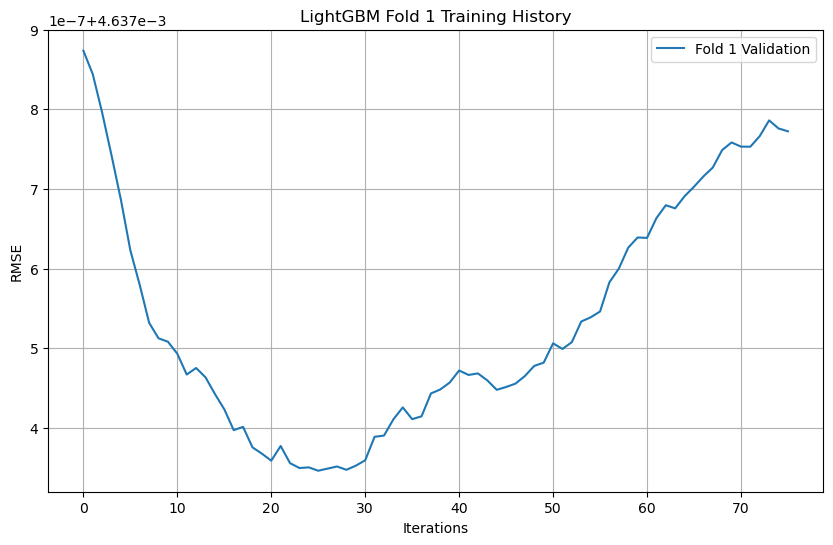

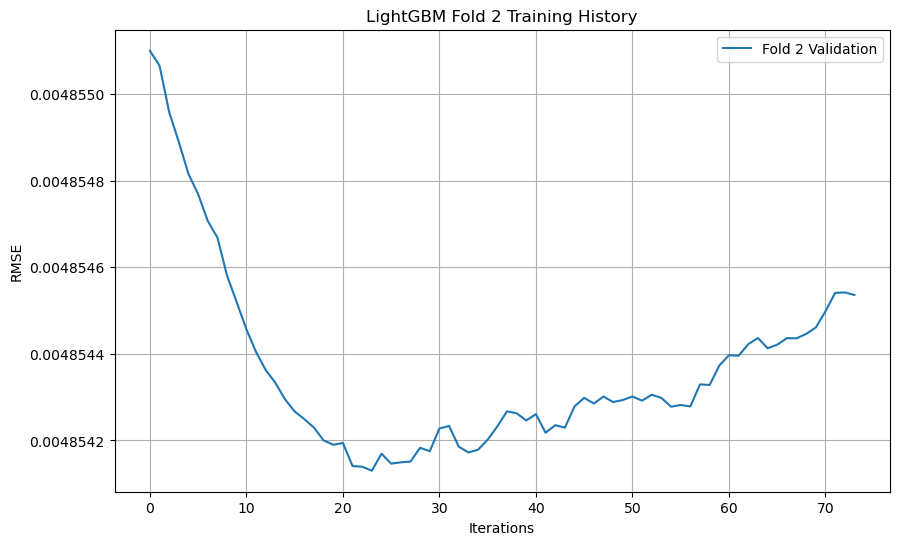

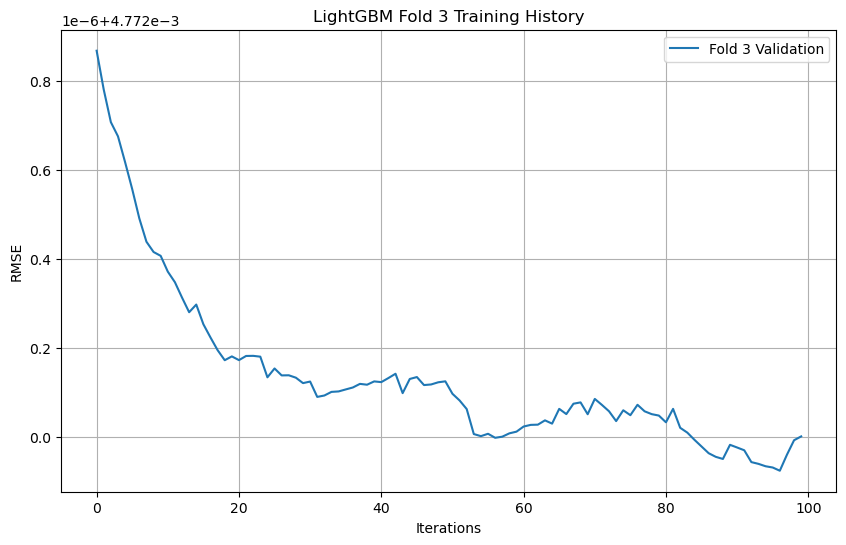

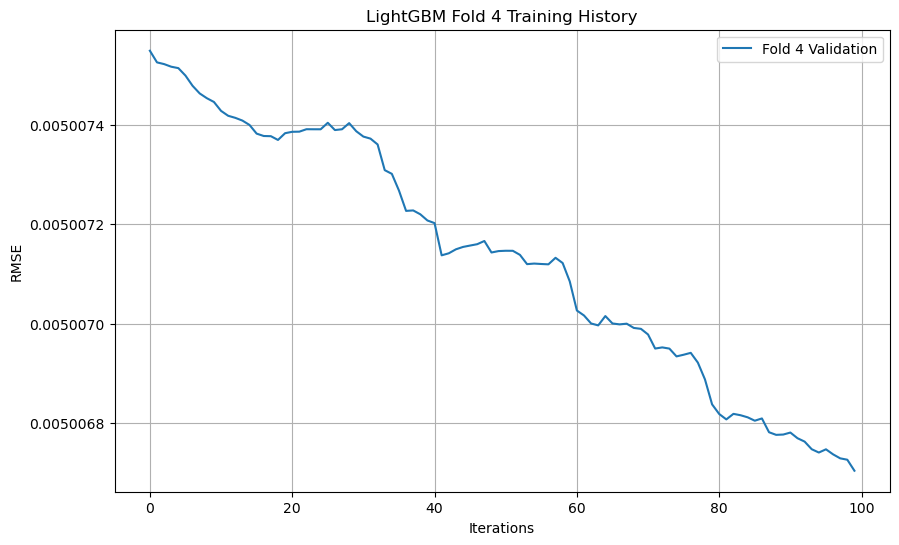

In [35]:
import matplotlib.pyplot as plt

for i, model in enumerate(modellist):
    results = model.evals_result_
    plt.figure(figsize=(10, 6))
    plt.plot(results['valid_0']['rmse'], label=f'Fold {i+1} Validation')
    plt.title(f'LightGBM Fold {i+1} Training History')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

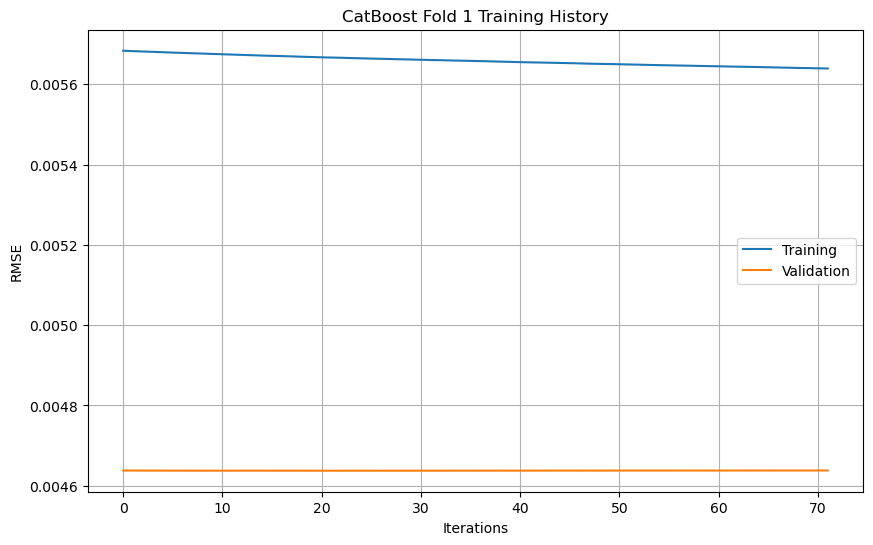

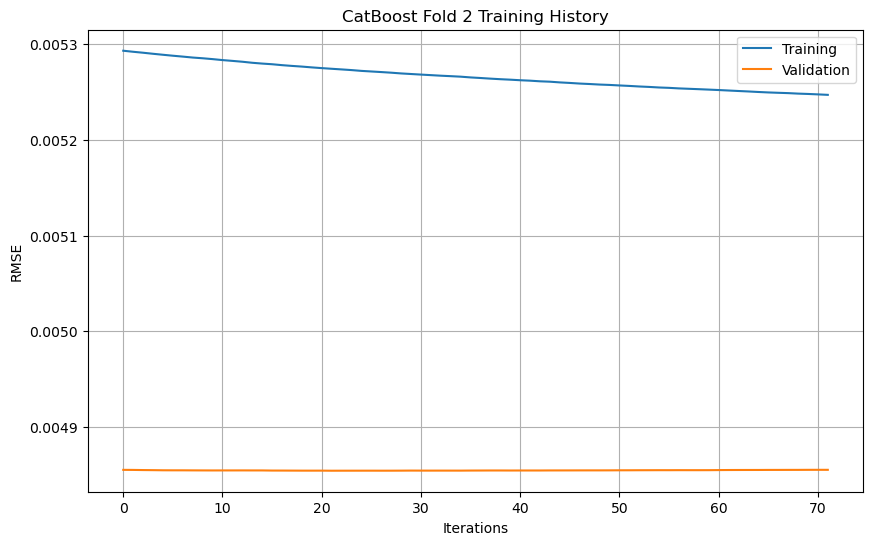

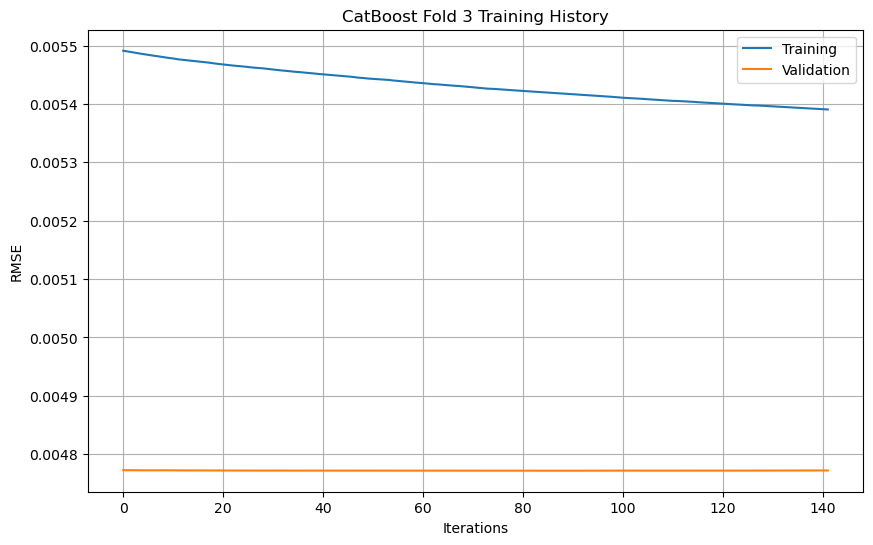

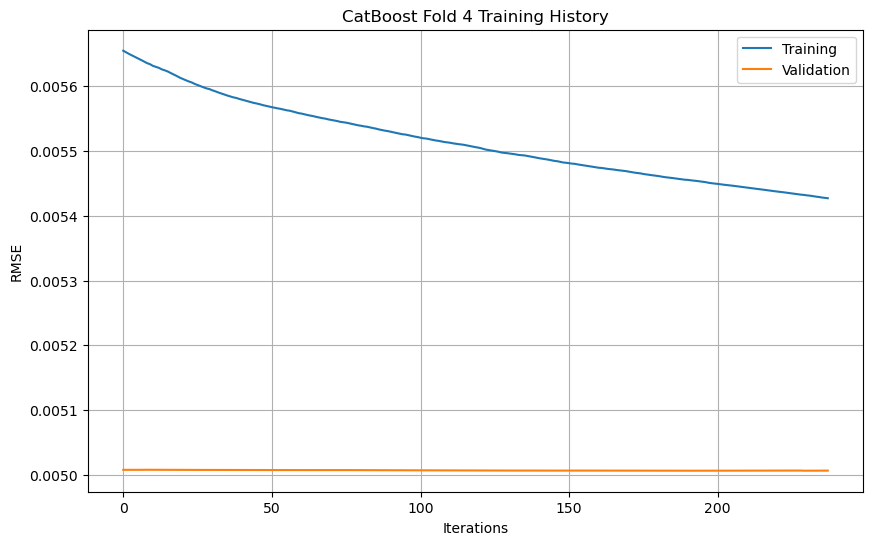

In [37]:
for i, model in enumerate(modellist_cat):
    results = model.get_evals_result()
    plt.figure(figsize=(10, 6))
    plt.plot(results['learn']['RMSE'], label='Training')
    plt.plot(results['validation']['RMSE'], label='Validation')
    plt.title(f'CatBoost Fold {i+1} Training History')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

<Figure size 1200x800 with 0 Axes>

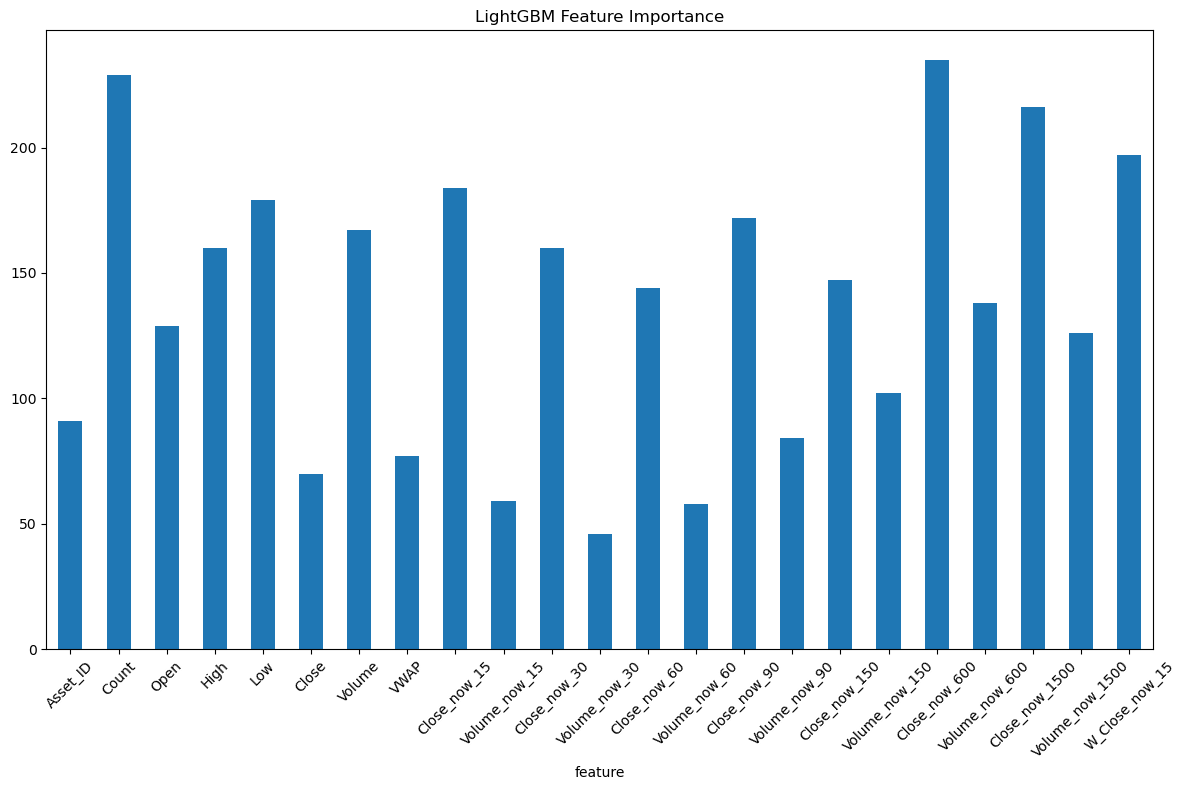

In [39]:
plt.figure(figsize=(12, 8))
for i, model in enumerate(modellist):
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_,
        'fold': i+1
    })
    if i == 0:
        ax = importance.plot.bar(x='feature', y='importance', legend=False, 
                               figsize=(12, 8), title='LightGBM Feature Importance')
    else:
        importance.plot.bar(x='feature', y='importance', legend=False, ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

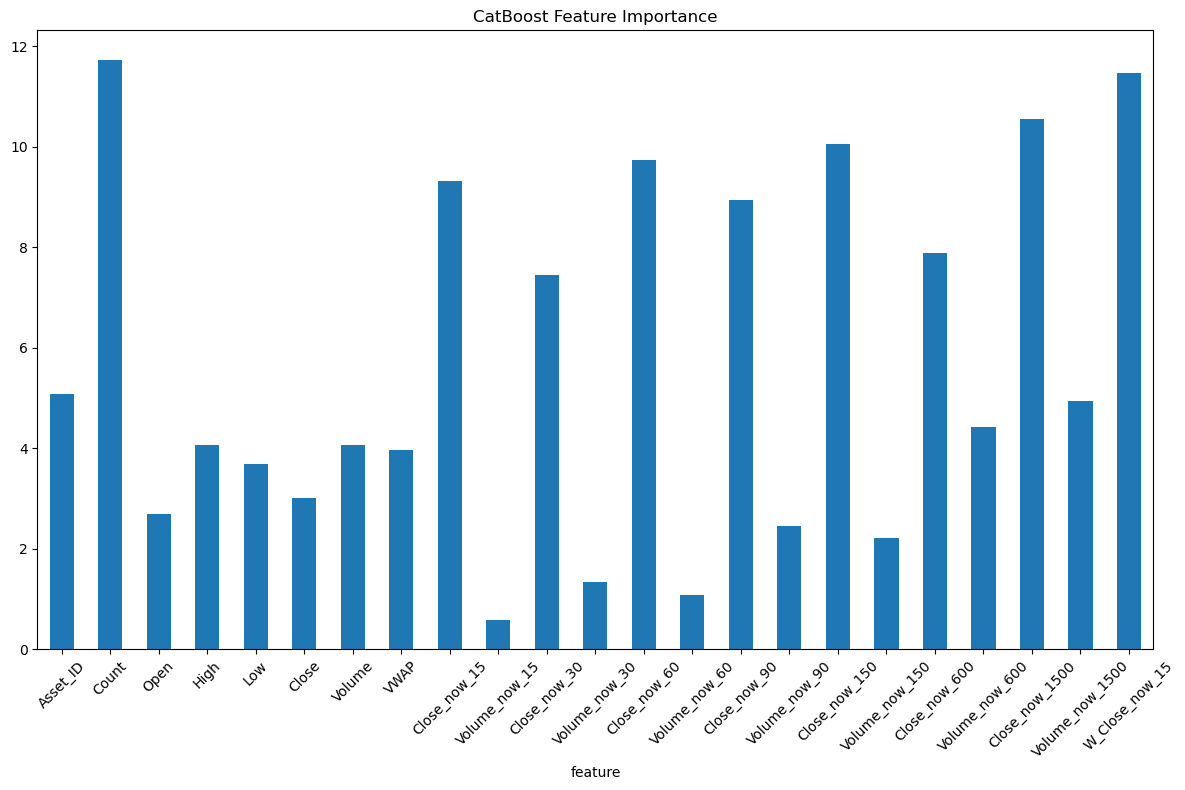

In [21]:
plt.figure(figsize=(12, 8))
for i, model in enumerate(modellist_cat):
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.get_feature_importance(),
        'fold': i+1
    })
    if i == 0:
        ax = importance.plot.bar(x='feature', y='importance', legend=False, 
                               figsize=(12, 8), title='CatBoost Feature Importance')
    else:
        importance.plot.bar(x='feature', y='importance', legend=False, ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

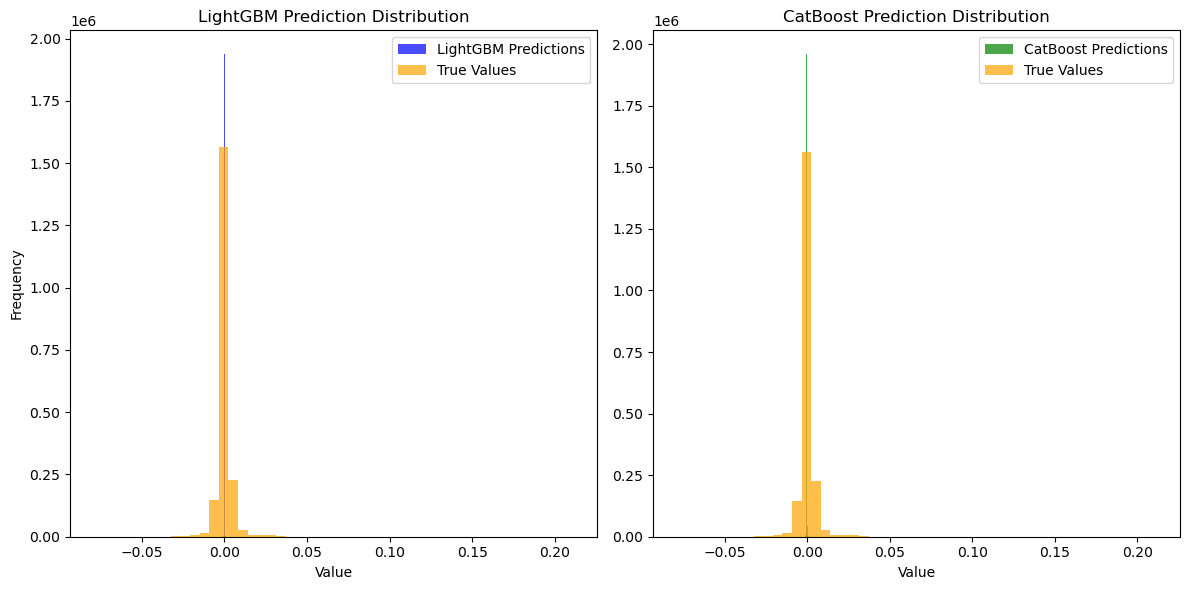

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(final_predictions, bins=50, alpha=0.7, color='blue', label='LightGBM Predictions')
plt.hist(df_test[target], bins=50, alpha=0.7, color='orange', label='True Values')
plt.title('LightGBM Prediction Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(final_predictions_cat, bins=50, alpha=0.7, color='green', label='CatBoost Predictions')
plt.hist(df_test[target], bins=50, alpha=0.7, color='orange', label='True Values')
plt.title('CatBoost Prediction Distribution')
plt.xlabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

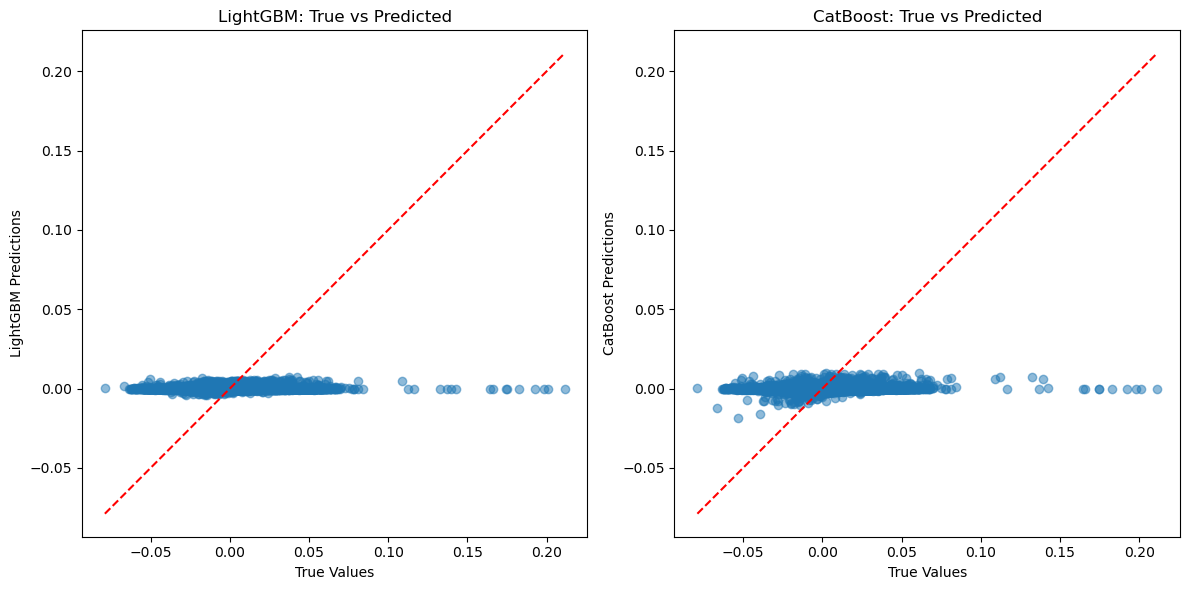

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_test[target], final_predictions, alpha=0.5)
plt.plot([min(df_test[target]), max(df_test[target])], 
         [min(df_test[target]), max(df_test[target])], 'r--')
plt.xlabel('True Values')
plt.ylabel('LightGBM Predictions')
plt.title('LightGBM: True vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(df_test[target], final_predictions_cat, alpha=0.5)
plt.plot([min(df_test[target]), max(df_test[target])], 
         [min(df_test[target]), max(df_test[target])], 'r--')
plt.xlabel('True Values')
plt.ylabel('CatBoost Predictions')
plt.title('CatBoost: True vs Predicted')

plt.tight_layout()
plt.show()

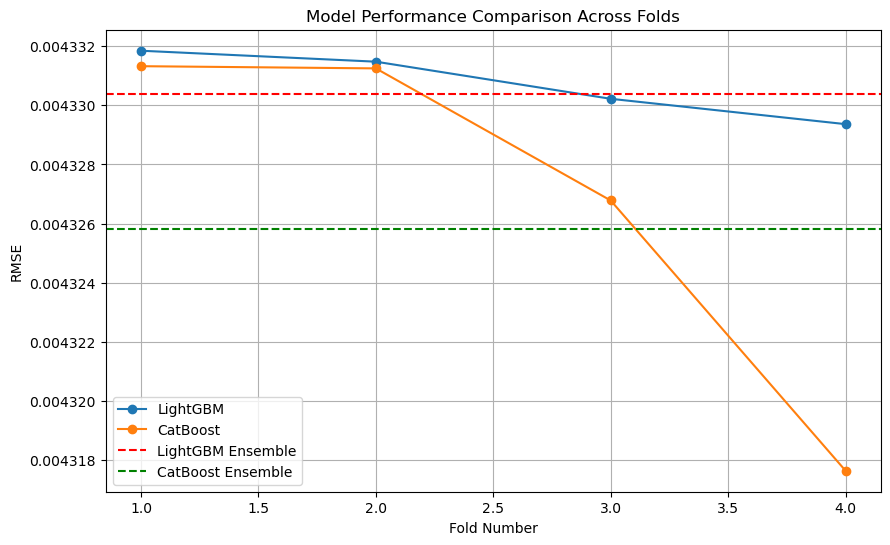

In [45]:
lgb_rmses = [mean_squared_error(df_test[target], test_predictions[:, i], squared=False) 
             for i in range(len(enumeratelist))]
cat_rmses = [mean_squared_error(df_test[target], test_predictions_cat[:, i], squared=False) 
            for i in range(len(enumeratelist))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(enumeratelist)+1), lgb_rmses, 'o-', label='LightGBM')
plt.plot(range(1, len(enumeratelist)+1), cat_rmses, 'o-', label='CatBoost')
plt.axhline(test_rmse, color='r', linestyle='--', label='LightGBM Ensemble')
plt.axhline(test_rmse_cat, color='g', linestyle='--', label='CatBoost Ensemble')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison Across Folds')
plt.legend()
plt.grid()
plt.show()